Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

2025-06-20 00:43:29.481399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750380209.690658      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750380209.751505      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Load and Preprocess Dataset

In [3]:
# Load the dataset
train = pd.read_parquet("/kaggle/input/d/shuvookd/unsw-nb15/UNSW_NB15_testing-set.parquet")
test = pd.read_parquet("/kaggle/input/d/shuvookd/unsw-nb15/UNSW_NB15_testing-set.parquet")

# Combine train and test data
df = pd.concat([train, test])

# Drop unnecessary columns
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')

# Convert categorical columns to numerical
cat_cols = ['proto', 'service', 'state']
for col in cat_cols:
    df[col] = pd.factorize(df[col])[0]

# Separate features and target variable
X = df.drop('label', axis=1)
y = df['label']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create DataFrame from scaled data
X = pd.DataFrame(X_scaled, columns=X.columns)


Define MoCo Encoder, Contrastive Loss, and Augmentation Functions

In [5]:
# Define MoCo encoder
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.Dense(128, activation='swish')(x)
    projection = layers.Dense(64)(x)  # Projection head
    return models.Model(inputs, projection)

# Define contrastive loss function
def contrastive_loss(query, key, queue, temperature=0.07):
    query = tf.math.l2_normalize(query, axis=1)
    key = tf.math.l2_normalize(key, axis=1)
    queue = tf.math.l2_normalize(queue, axis=1)

    l_pos = tf.reshape(tf.reduce_sum(query * key, axis=1), [-1,1])  # Positive similarity
    l_neg = tf.matmul(query, queue, transpose_b=True)              # Negative similarities

    logits = tf.concat([l_pos, l_neg], axis=1) / temperature
    labels = tf.zeros(logits.shape[0], dtype=tf.int32)  # positives are first

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits)
    return tf.reduce_mean(loss)

# Data augmentation function
def augment_batch(X):
    mask = (np.random.rand(*X.shape) > 0.15).astype(np.float32)
    noise = np.random.normal(0, 0.05, size=X.shape).astype(np.float32)
    return X * mask + noise


 Define MoCo Queue and Momentum Update

In [7]:
# Queue and momentum encoder
embedding_dim = 64
queue_size = 65536

queue = tf.Variable(tf.random.normal([queue_size, embedding_dim]), trainable=False)
queue.assign(tf.math.l2_normalize(queue, axis=1))
queue_ptr = tf.Variable(0, trainable=False, dtype=tf.int32)

# Dequeue and enqueue function
@tf.function
def dequeue_and_enqueue(new_keys):
    batch_size = tf.shape(new_keys)[0]
    ptr = queue_ptr.value()
    update_indices = tf.range(ptr, ptr + batch_size) % queue_size
    queue.scatter_nd_update(tf.expand_dims(update_indices, 1), new_keys)
    queue_ptr.assign((ptr + batch_size) % queue_size)

# Momentum update function
@tf.function
def momentum_update(query_encoder, key_encoder, m=0.999):
    for q_var, k_var in zip(query_encoder.trainable_variables, key_encoder.trainable_variables):
        k_var.assign(m * k_var + (1 - m) * q_var)


Train the Model with Different Train-Test Ratios & Save Result

In [8]:
# Define ratios and result storage
ratios = [(10,90), (20,80), (30,70), (40,60), (50,50), (60,40), (70,30), (80,20), (90,10)]
all_results = []

# Loop over different train-test splits
for train_pct, test_pct in ratios:
    print(f"\n--- Train:Test = {train_pct}:{test_pct} ---")

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X.values.astype(np.float32), y.values,
        test_size=test_pct/100,
        stratify=y,
        random_state=42
    )

    # Initialize encoders and optimizer
    query_encoder = build_encoder(X_train.shape[1])
    key_encoder = build_encoder(X_train.shape[1])

    # Initialize encoder weights to be identical
    for q_var, k_var in zip(query_encoder.variables, key_encoder.variables):
        k_var.assign(q_var)

    optimizer = tf.keras.optimizers.Adam(3e-4)
    batch_size = 512
    epochs = 20
    num_samples = X_train.shape[0]

    # Training loop for each epoch
    for epoch in range(epochs):
        idx = np.random.permutation(num_samples)
        X_shuffled = X_train[idx]

        for i in range(0, num_samples, batch_size):
            batch = X_shuffled[i:i+batch_size]
            if batch.shape[0] < 2:
                continue

            # Augment the batch for query and key
            x_q = augment_batch(batch)
            x_k = augment_batch(batch)

            with tf.GradientTape() as tape:
                z_q = query_encoder(x_q, training=True)
                z_k = key_encoder(x_k, training=True)
                loss = contrastive_loss(z_q, z_k, queue)

            grads = tape.gradient(loss, query_encoder.trainable_variables)
            optimizer.apply_gradients(zip(grads, query_encoder.trainable_variables))

            # Apply momentum update to the key encoder
            momentum_update(query_encoder, key_encoder)
            dequeue_and_enqueue(tf.stop_gradient(z_k))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy():.4f}")

        # Evaluate with Random Forest Classifier
        X_train_ssl = query_encoder.predict(X_train)
        X_test_ssl = query_encoder.predict(X_test)

        rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
        rf.fit(X_train_ssl, y_train)
        y_pred = rf.predict(X_test_ssl)
        report = classification_report(y_test, y_pred, output_dict=True)

        acc = report['accuracy']
        f1_0 = report['0']['f1-score']
        f1_1 = report['1']['f1-score']

        # Store the results for later analysis
        all_results.append({
            'train_pct': train_pct,
            'test_pct': test_pct,
            'epoch': epoch + 1,
            'loss': float(loss.numpy()),
            'accuracy': acc,
            'f1_class_0': f1_0,
            'f1_class_1': f1_1
        })

        print(f"Accuracy: {acc:.4f}, F1 Class 0: {f1_0:.4f}, F1 Class 1: {f1_1:.4f}")

# Convert the results to a DataFrame and save to CSV
results_df = pd.DataFrame(all_results)
results_df.to_csv('moco_results_all_epochs.csv', index=False)
print("\nSaved results to 'moco_results_all_epochs.csv'")


--- Train:Test = 10:90 ---
Epoch 1/20, Loss: 7.0267


I0000 00:00:1750380284.542401      86 service.cc:148] XLA service 0x7c8cb0003e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750380284.542938      86 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750380284.542956      86 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750380284.616112      86 cuda_dnn.cc:529] Loaded cuDNN version 90300


137/515 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1750380284.843686      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
4632/4632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Accuracy: 0.9087, F1 Class 0: 0.9009, F1 Class 1: 0.9153
Epoch 2/20, Loss: 7.0453
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
4632/4632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Accuracy: 0.9087, F1 Class 0: 0.9009, F1 Class 1: 0.9153
Epoch 3/20, Loss: 7.7166
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
4632/4632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Accuracy: 0.9081, F1 Class 0: 0.9003, F1 Class 1: 0.9147
Epoch 4/20, Loss: 7.4177
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
4632/4632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Accuracy: 0.9089, F1 Class 0: 0.9012, F1 Class 1: 0.9155
Epoch 5/20, Loss: 7.5851
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
4632/4632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Accuracy: 0.9089, F1 Class 0: 0.9011, F1 Class 1: 0.9155
Epoch 6/20, Loss: 7.5942
515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
4632/4632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Accuracy: 0.9094, F1 Class 0: 0.9015, F1 Class 1: 0.9161
Epoch 7/20, Loss: 7.3698
515/

 Visualize the Results

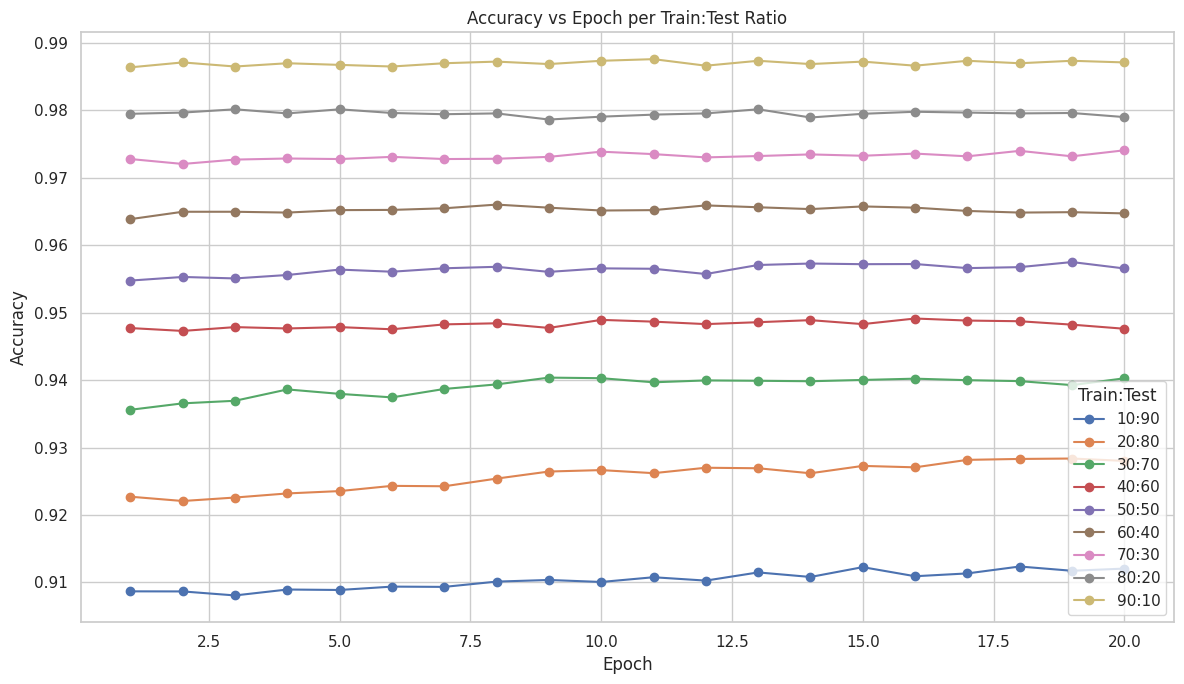

In [9]:
# Visualization of Accuracy vs Epoch and Loss vs Epoch
sns.set(style="whitegrid")
ratios_unique = results_df[['train_pct', 'test_pct']].drop_duplicates()

# Accuracy vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['accuracy'], marker='o', label=label)
plt.title("Accuracy vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()

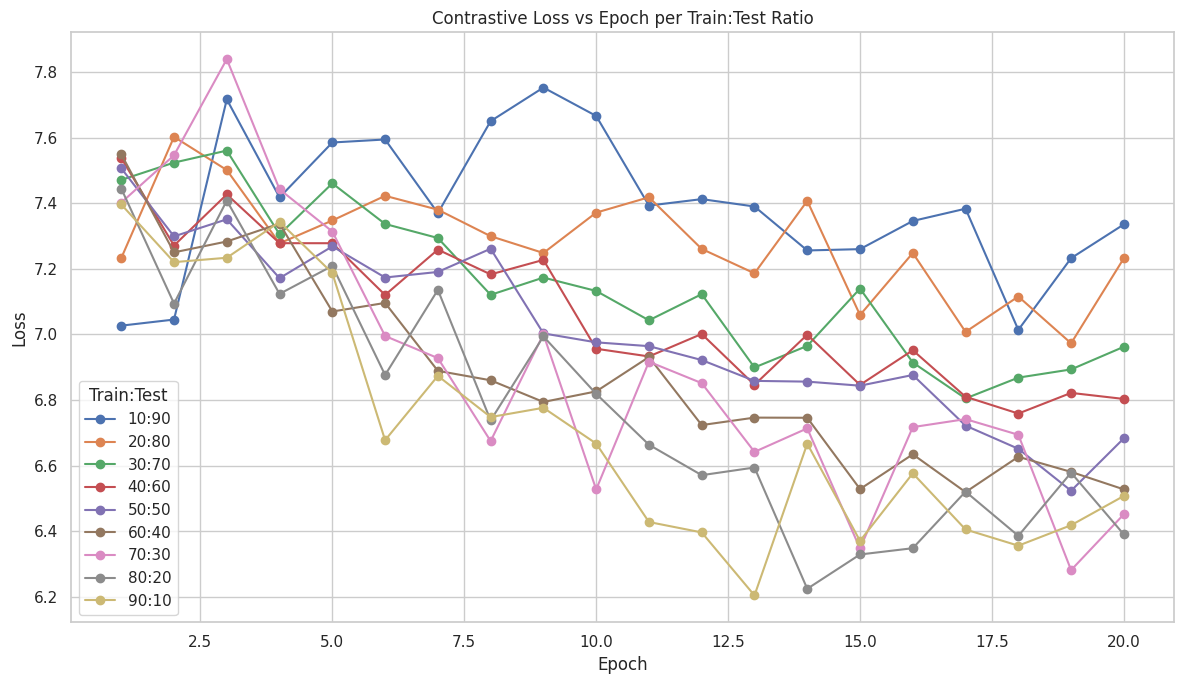

In [10]:
# Loss vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['loss'], marker='o', label=label)
plt.title("Contrastive Loss vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()

/tmp/ipykernel_35/2560087156.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="train_pct", y="accuracy", hue="test_pct", data=final_results, ci=None)


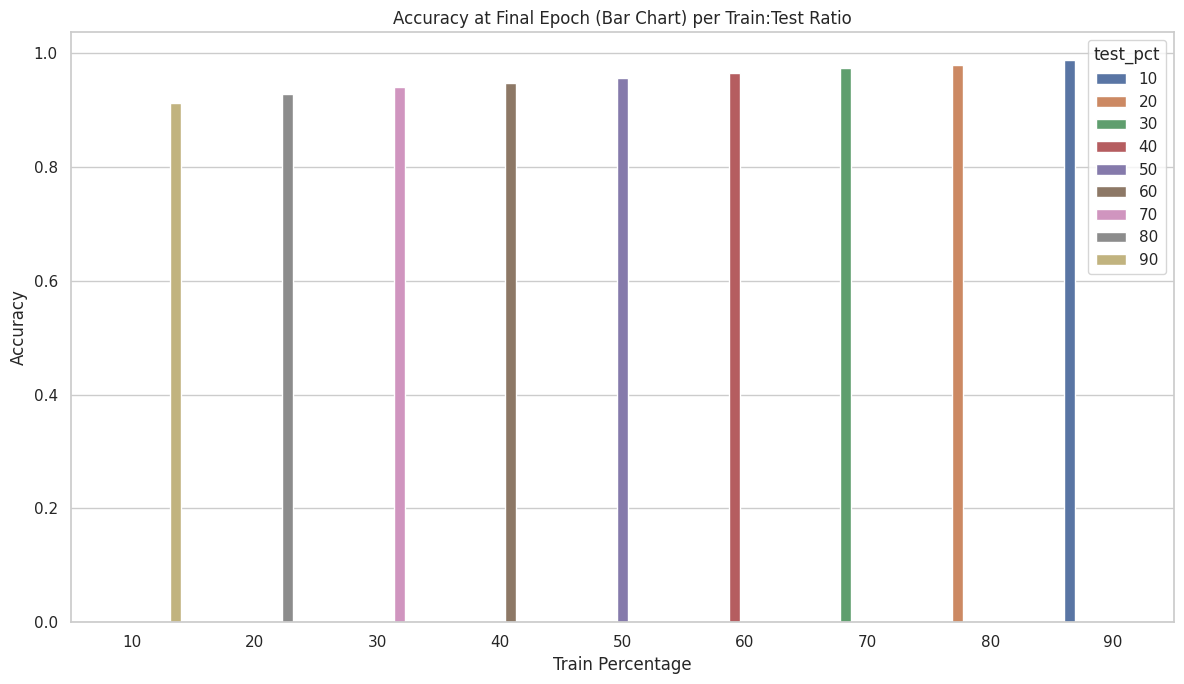

/tmp/ipykernel_35/2560087156.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="train_pct", y="loss", hue="test_pct", data=final_results, ci=None)


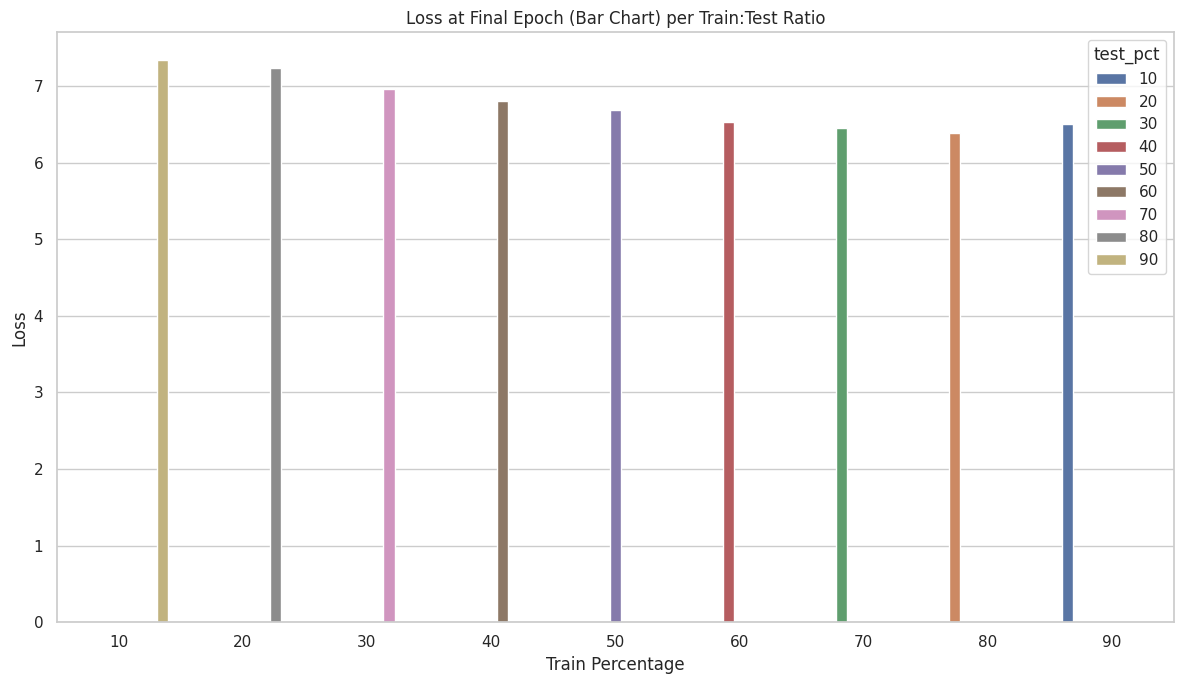

In [11]:
# Visualization of Accuracy and Loss at Final Epoch using Bar Chart
final_results = results_df[results_df['epoch'] == 20]  # Assuming 20 epochs for the final result

# Accuracy Bar Chart
plt.figure(figsize=(12, 7))
sns.barplot(x="train_pct", y="accuracy", hue="test_pct", data=final_results, ci=None)
plt.title("Accuracy at Final Epoch (Bar Chart) per Train:Test Ratio")
plt.xlabel("Train Percentage")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# Loss Bar Chart
plt.figure(figsize=(12, 7))
sns.barplot(x="train_pct", y="loss", hue="test_pct", data=final_results, ci=None)
plt.title("Loss at Final Epoch (Bar Chart) per Train:Test Ratio")
plt.xlabel("Train Percentage")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()